Original Data Shape: (6, 8)
      address  precipitation  river_level  soil_moisture  recovery_funds  \
0   Kundapura             50          2.5             30          200000   
1       Udupi             10          1.2             15           10000   
2  Koteshwara             70          3.0             40            5000   
3     Shiroor             20          1.0             20           25819   
4    Bhatkala            100          3.5             60           18483   

   infrastructure_damage  population_affected  flood_occurred  
0                   3000               100000               1  
1                      9                  200               1  
2                     19                  290               1  
3                      2                   80               0  
4                      1                  138               0  
Data After Geolocation Shape: (6, 11)
      address   latitude  longitude
0   Kundapura  13.625099  74.691572
1       Udupi  13.341

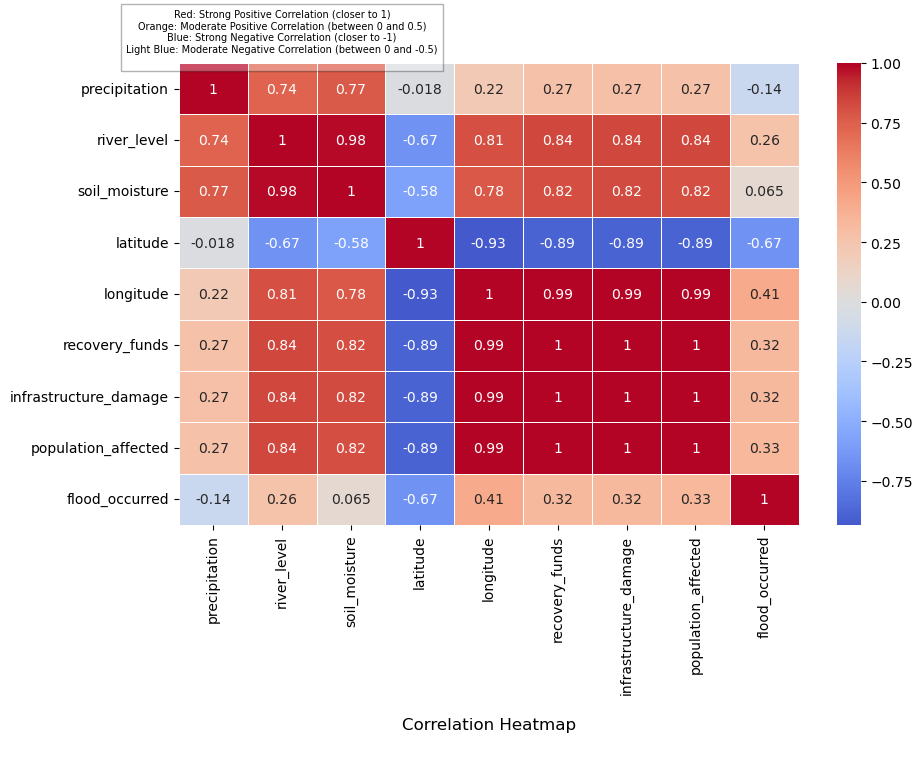

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
try:
    data = pd.read_csv("dummy-flood-dataset.csv")
    print("Original Data shape:", data.shape)
    print(data.head())
except Exception as e:
    print("Error loading dataset:", e)
    exit()

# Step 2: Preprocess the data
geolocator = Nominatim(user_agent="flood_predictor")

def geocode_address(address):
    try:
        return geolocator.geocode(address)
    except Exception as e:
        print(f"Error geocoding address {address}: {e}")
        return None

data['location'] = data['address'].apply(geocode_address)
data['latitude'] = data['location'].apply(lambda loc: loc.latitude if loc else None)
data['longitude'] = data['location'].apply(lambda loc: loc.longitude if loc else None)

print("Data After Geolocation Shape:", data.shape)
print(data[['address', 'latitude', 'longitude']].head())

# Dropping rows with missing latitude or longitude
data = data.dropna(subset=['latitude', 'longitude'])
print("Data After Dropping Missing Geo Data Shape:", data.shape)

print("Target Variable Distribution:")
print(data['flood_occurred'].value_counts())

# Step 3: Feature engineering
# Adding features for post-flood recovery assessment
# Example features: 'recovery_funds', 'infrastructure_damage', 'population_affected', 'emergency_response_time'
features = ['precipitation', 'river_level', 'soil_moisture', 'latitude', 'longitude',
            'recovery_funds', 'infrastructure_damage', 'population_affected']
X = data[features]
y = data['flood_occurred']


# Step 4: Train the model
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
except Exception as e:
    print("Error training the model:", e)
    exit()

# Step 5: Make predictions for the entire dataset
try:
    data['prediction'] = model.predict(X)
except Exception as e:
    print("Error making predictions:", e)
    exit()

for idx, row in data.iterrows():
    status = "will" if row['prediction'] == 1 else "will not"
    print(f"The place at address {row['address']} ({row['latitude']}, {row['longitude']}) {status} experience a flood.")

# Step 6: Post-flood recovery assessment and prediction
# Example assessment and prediction code based on recovery-related features
def assess_recovery(row):
    if row['recovery_funds'] > 500000 and row['infrastructure_damage'] > 100 and row['population_affected'] > 1000 :
        return "Recovery is likely to be fast"
    else:
        return "Recovery may be slow"

data['recovery_assessment'] = data.apply(assess_recovery, axis=1)

for idx, row in data.iterrows():
    print(f"Post-flood recovery assessment for address {row['address']} ({row['latitude']}, {row['longitude']}): {row['recovery_assessment']}")

# Step 7: Plotting the correlation heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = data[features + ['flood_occurred']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, center=0)

plt.xlabel('\nCorrelation Heatmap\n', fontsize=12)

# Adding color interpretation
plt.text(1.5, -0.5, "Red: Strong Positive Correlation (closer to 1)\n"
                   "Orange: Moderate Positive Correlation (between 0 and 0.5)\n"
                   "Blue: Strong Negative Correlation (closer to -1)\n"
                   "Light Blue: Moderate Negative Correlation (between 0 and -0.5)\n"
                 ,
         ha='center', va='center', fontsize=7, color='black', bbox=dict(facecolor='white', alpha=0.3))

plt.show()

